In [1]:
import numpy as np 
import pandas as pd 
import nltk
import spacy 
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

## Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Embedding,Bidirectional,LSTM,InputLayer
from keras.activations import sigmoid,relu

In [2]:
test_data1=pd.read_csv("/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge/test.csv")
test_data_labels=pd.read_csv("/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge/test_labels.csv")

In [3]:
test_data=pd.merge(test_data1,test_data_labels,how='left',on='id')
test_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",-1,-1,-1,-1,-1,-1


In [4]:
train_data=pd.read_csv("/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge/train.csv")
train_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [5]:
data=pd.concat([train_data,test_data])

In [6]:
data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",-1,-1,-1,-1,-1,-1


In [7]:
data['y'] = (data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) > 0 ).astype(int)
data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,y
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",-1,-1,-1,-1,-1,-1,0
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,-1,-1,-1,-1,-1,-1,0
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",-1,-1,-1,-1,-1,-1,0
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",-1,-1,-1,-1,-1,-1,0


In [8]:
data['y'].value_counts()

0    290267
1     22468
Name: y, dtype: int64

In [9]:
data_one=data[data['y'] ==1]
data_zeros=data[data['y']==0]

In [10]:
data_zero=data_zeros.sample(n=22468)

In [11]:
data_zero

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,y
122145,cbfa5489de512525,== quoting main page == \n\n Swede Anja Pärson...,0,0,0,0,0,0,0
48836,8290c211100c772a,"I agree with r-b j, they actually believe them...",0,0,0,0,0,0,0
147656,f6d2e58633835d56,""" \n ::Your team obviously feels strongly that...",-1,-1,-1,-1,-1,-1,0
2727,075744ca0099fad8,"""\n\nFinally, I would not be referring to the ...",0,0,0,0,0,0,0
46757,7cf1fdaa0d3e1a3b,Please stop. If you continue to blank out (or ...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
57468,99b1c5bed5a5f8ea,You're asking for original research. (not allo...,0,0,0,0,0,0,0
133338,dee659c113f44180,== shutup == \n\n The whole thing is stupid!!!,-1,-1,-1,-1,-1,-1,0
152671,ff2a0602fc19d1cc,== Madde == \n\n Bu madde yalan Olmuş !!!! \n\...,0,0,0,0,0,0,0
112296,58b2f717de211f90,"""\nThe situation is not analogous. The definit...",0,0,0,0,0,0,0


In [12]:
_data=pd.concat([data_zero,data_one])
_data=_data.sample(frac=1)
_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,y
84567,e24146fa747932c2,you study this situation: Luigi is active edit...,1,0,0,0,0,0,1
39056,40c96364e91d5b45,:I've been rather lax on my mentoring over the...,0,0,0,0,0,0,0
80288,85f3d6b01092da70,== Semi-protected edit request on 20 June 2014...,-1,-1,-1,-1,-1,-1,0
83957,e0aace9ff80b7283,SUCK MY PLUMS YOU STUPID SEPTIC CUNT,1,1,1,0,1,0,1
104572,2f75fae249978cd8,I strongly object to the proposal of creating ...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
28076,4a4c80ea2ce9689a,""":Hi Abu, (may I call you Abu? it's been so of...",0,0,0,0,0,0,0
131107,db1e4ca00b255420,lecz z twoimi danymi,-1,-1,-1,-1,-1,-1,0
28782,4c447b30e01d4b63,"""\n\n Was Diem a gay homosexual dictator? \nHe...",1,0,0,0,1,0,1
126093,a25d59cac7eaadd9,"""\n\nLooks like I won this one. Anyway, I was...",1,0,1,0,1,0,1


In [13]:

new_data=_data[['comment_text','y']]

In [14]:
new_data

,comment_text,y
84567,you study this situation: Luigi is active edit...,1
39056,:I've been rather lax on my mentoring over the...,0
80288,== Semi-protected edit request on 20 June 2014...,0
83957,SUCK MY PLUMS YOU STUPID SEPTIC CUNT,1
104572,I strongly object to the proposal of creating ...,0
...,...,...
28076,""":Hi Abu, (may I call you Abu? it's been so of...",0
131107,lecz z twoimi danymi,0
28782,"""\n\n Was Diem a gay homosexual dictator? \nHe...",1
126093,"""\n\nLooks like I won this one. Anyway, I was...",1


In [15]:
new_data['y'].value_counts()

1    22468
0    22468
Name: y, dtype: int64

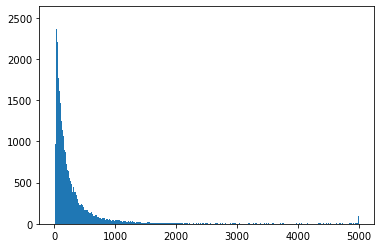

In [16]:
## Plotting the histogram to check the distribution of length of each reviews. 
plt.hist([len(x) for x in new_data['comment_text']], bins=500)
plt.show()

In [17]:
## Hyper-parameters considered for building the model
embedding_dim = 300
max_length = 1000
padding_type = 'post'
trunc_type = 'post'
oov_tok = "<oov>"

In [18]:
## Tokenizing the sentenes
tokenizer = Tokenizer(oov_token = oov_tok)
tokenizer.fit_on_texts(new_data['comment_text'])
word_index = tokenizer.word_index

In [19]:
##training sequences and labels
train_seqs = tokenizer.texts_to_sequences(new_data['comment_text'])
train_padded = pad_sequences(train_seqs,maxlen=max_length, truncating=trunc_type)

In [20]:
## Model Architecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index)+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [21]:
## Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 300)         28075500  
                                                                 
 bidirectional (Bidirectiona  (None, 1000, 512)        1140736   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              656384    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 29,905,645
Trainable params: 29,905,645
No

In [22]:
## Compiling the model. The loss function considered is binary crossentropy as we are predicting on only two classes. 
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [23]:
## Input to tesnorflow model should always be np array format
train_labels = np.array(new_data["y"])


In [24]:
## Make sure to use GPU before running this cell. Time takes per epoch without gpu is 19 min
num_epochs = 10
## For early stopping to ensure it doesnt overfit
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = model.fit(
    train_padded, 
    train_labels, 
    epochs=num_epochs,
    batch_size = 256,
    callbacks=[callback],
    use_multiprocessing=True
    )

Epoch 1/10
176/176 [==============================] - 407s 2s/step - loss: 0.4187 - accuracy: 0.8119
Epoch 2/10
176/176 [==============================] - 396s 2s/step - loss: 0.2565 - accuracy: 0.9049
Epoch 3/10
176/176 [==============================] - 397s 2s/step - loss: 0.1915 - accuracy: 0.9346
Epoch 4/10
176/176 [==============================] - 396s 2s/step - loss: 0.1487 - accuracy: 0.9501
Epoch 5/10
176/176 [==============================] - 395s 2s/step - loss: 0.1340 - accuracy: 0.9525
Epoch 6/10
176/176 [==============================] - 397s 2s/step - loss: 0.0924 - accuracy: 0.9682
Epoch 7/10
176/176 [==============================] - 398s 2s/step - loss: 0.0702 - accuracy: 0.9755
Epoch 8/10
176/176 [==============================] - 399s 2s/step - loss: 0.0574 - accuracy: 0.9795
Epoch 9/10
176/176 [==============================] - 397s 2s/step - loss: 0.0427 - accuracy: 0.9849
Epoch 10/10
176/176 [==============================] - 396s 2s/step - loss: 0.0339 - accura

In [25]:
 ## Reading the comments that we need to score
df_ = pd.read_csv("/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge/test.csv")

In [27]:
df_

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [28]:
## Extracting the text and converting it for the model 
X_ = tokenizer.texts_to_sequences(df_['comment_text'])
test_padded = pad_sequences(X_, maxlen=max_length, truncating=trunc_type)

In [29]:
pred = model.predict(test_padded)


In [30]:
pred

array([[9.9985063e-01],
       [1.6627452e-04],
       [1.7087425e-04],
       ...,
       [1.0016408e-03],
       [3.2316293e-05],
       [5.4646593e-01]], dtype=float32)

In [31]:
df_['score'] = pred

In [32]:
df_

,id,comment_text,score
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0.999851
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0.000166
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0.000171
3,00017563c3f7919a,":If you have a look back at the source, the in...",0.000172
4,00017695ad8997eb,I don't anonymously edit articles at all.,0.000032
...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",0.011334
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,0.150059
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",0.001002
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",0.000032


In [34]:
df_.iloc[4]['comment_text']

"I don't anonymously edit articles at all."